In [7]:
import sqlite3
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Masking
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

In [ ]:
conn = sqlite3.connect(r'C:\Users\opper\Master-Arbeit\data\preprocessed\pv_forecast.db')

query = f"""
SELECT "Date time", Location, shortwave_radiation_tilted, Temperature, AOI, "Cloud Cover", "Relative Humidity", "kW/kWp"
FROM pv_weather_data
ORDER BY Location, "Date time" ASC
"""
# Daten abrufen und in ein DataFrame laden
df = pd.read_sql(query, conn)
conn.close()

# Ausgabe des DataFrames zum Überprüfen


print("Anzahl NaN-Werte pro Spalte:\n", df.isna().sum())

# Falls es NaN-Werte gibt, betroffene Zeilen anzeigen
if df.isna().sum().sum() > 0:
    print("\nZeilen mit NaN-Werten:")
    print(df[df.isna().any(axis=1)])

Anzahl NaN-Werte pro Spalte:
 Date time                     0
Location                      0
shortwave_radiation_tilted    0
Temperature                   0
kW/kWp                        0
dtype: int64


In [5]:
def get_sliding_window(df, datetime_col, feature_cols, target_col, window_size=480, forecast_horizon=96, step_size=1):
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    df = df.sort_values(by=datetime_col).reset_index(drop=True)

    feature_data = df[feature_cols].values
    target_data = df[target_col].values
    

    X, y = [], []

    for i in range(0, len(df) - window_size - forecast_horizon, step_size):
        X_seq = feature_data[i : i + window_size].copy()

        X_seq[-forecast_horizon:, -1] = -1

        y_seq = target_data[i + window_size - forecast_horizon : i + window_size]

        X.append(X_seq)  # Input-Sequenz
        y.append(y_seq)  # Zielwerte
        

    return np.array(X), np.array(y)

In [ ]:
feature_cols = ["shortwave_radiation_tilted", "Temperature", "AOI", "Cloud Cover", "Relative Humidity","kW/kWp"]
target_col = "kW/kWp"

feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

df[feature_cols] = feature_scaler.fit_transform(df[feature_cols])
df[target_col] = target_scaler.fit_transform(df[[target_col]])


X_list, y_list = [], []
location_ids = []


for location in df["Location"].unique():
    print(f"Erstelle Sliding Windows für {location}...")

    df_location = df[df["Location"] == location].copy()

    X, y = get_sliding_window(df_location, datetime_col="Date time", feature_cols=feature_cols, target_col=target_col)

    X_list.append(X)
    y_list.append(y)
    

    location_ids.extend([location] * len(X))

X_final = np.concatenate(X_list, axis=0)  # Alle Input-Sequenzen
y_final = np.concatenate(y_list, axis=0)  # Alle Zielwerte

location_ids = np.array(location_ids)

np.save("X_tensor.npy", X_final)
np.save("y_tensor.npy", y_final)
np.save("location_ids.npy", location_ids)

print(f"Finaler Tensor X Shape: {X_final.shape}")  # (Samples, Timesteps=672, Features=3)
print(f"Finaler Tensor y Shape: {y_final.shape}")  # (Samples, Forecast_Horizon=96)
print(f"Finaler Tensor location.ids-Shape: {location_ids.shape}")

Erstelle Sliding Windows für bielefeldmel...
Erstelle Sliding Windows für bielefeldref...
Erstelle Sliding Windows für gaithersburg...
Erstelle Sliding Windows für hongkong...
Erstelle Sliding Windows für istanbul...
Erstelle Sliding Windows für victoria14...
Erstelle Sliding Windows für victoria15...
Erstelle Sliding Windows für victoria16...
Erstelle Sliding Windows für victoria17...
Finaler Tensor X Shape: (438007, 480, 3)
Finaler Tensor y Shape: (438007, 96)
Finaler Tensor y Shape: (438007,)


In [3]:
# Lade die gespeicherten Tensoren
X_final = np.load("X_tensor.npy")
y_final = np.load("y_tensor.npy")
location_ids = np.load("location_ids.npy")  # Lade die Standort-IDs

# Wähle einen Standort aus, z. B. "Bielefeld"
location = "hongkong"

# Finde die Indizes, an denen dieser Standort vorkommt
indices = np.where(location_ids == location)[0]

# Filtere die Sliding Windows für diesen Standort
X_location = X_final[indices]
y_location = y_final[indices]

print(f"Sliding Windows für {location}: {X_location.shape}")

NameError: name 'np' is not defined

In [65]:
window_index = 0

print(f"Zweites Sliding Window für {location}:")
print(X_location[window_index])

print(f"\nErster Zeitschritt im Sliding Window für {location}:")
print(X_location[window_index, 0])  

print(f"\nZielwerte (y) für das erste Sliding Window für {location}:")
print(y_location[window_index])

Zweites Sliding Window für hongkong:
[[ 0.          0.50652751  0.        ]
 [ 0.          0.50267552  0.        ]
 [ 0.          0.50089184  0.        ]
 ...
 [ 0.          0.56387097 -1.        ]
 [ 0.          0.56282732 -1.        ]
 [ 0.          0.56358634 -1.        ]]

Erster Zeitschritt im Sliding Window für hongkong:
[0.         0.50652751 0.        ]

Zielwerte (y) für das erste Sliding Window für hongkong:
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.99246138e-05
 1.35295703e-02 3.66846062e-02 7.47571168e-02 1.18091682e-01
 1.61785704e-01 2.17731226e-01 2.74705195e-01 3.27195934e-01
 3.89541792e-01 4.42262184e-0

In [ ]:
X_temp, X_test, y_temp, y_test, loc_temp, loc_test = train_test_split(
    X_final, y_final, location_ids,
    test_size=0.15,
    stratify=location_ids,
    random_state=42)


gkf = GroupKFold(n_splits=5)

fold_results = []
true_values = []
predicted_values = []

for fold, (train_idx, val_idx) in enumerate(gkf.split(X_temp, y_temp, groups=loc_temp)):
    X_train, X_val = X_temp[train_idx], X_temp[val_idx]
    y_train, y_val = y_temp[train_idx], y_temp[val_idx]

    model = Sequential([
        Masking(mask_value=-1, input_shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(64, activation="tanh", return_sequences=True),
        LSTM(32, activation="tanh"),
        Dense(96, activation='sigmoid')  
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=['mae'])

    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=32,
        validation_data=(X_val, y_val),
        verbose=1)
    
    fold_results.append(history.history)

    y_pred = model.predict(X_val)

    true_values.extend(y_val[:100])  
    predicted_values.extend(y_pred[:100])
avg_loss = np.mean([min(history['val_loss']) for history in fold_results])
print(f"Durchschnittlicher Validierungsverlust: {avg_loss:.4f}")

NameError: name 'X_final' is not defined

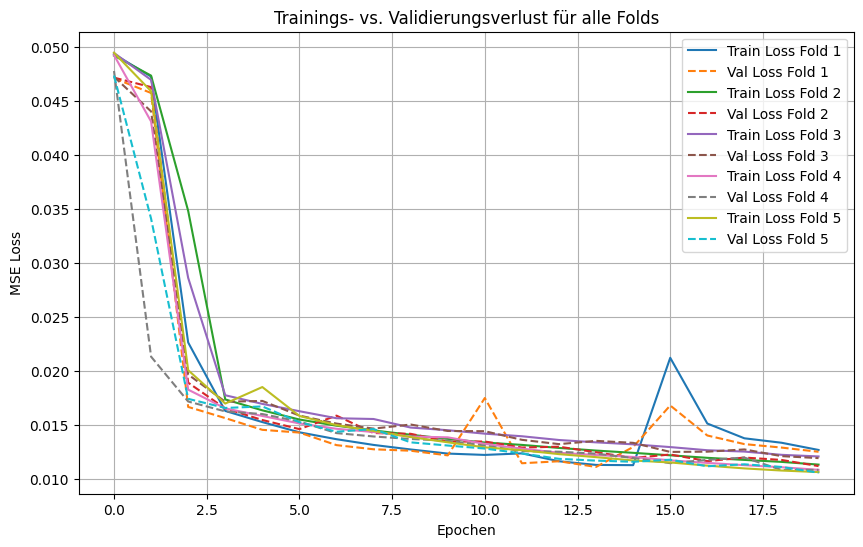

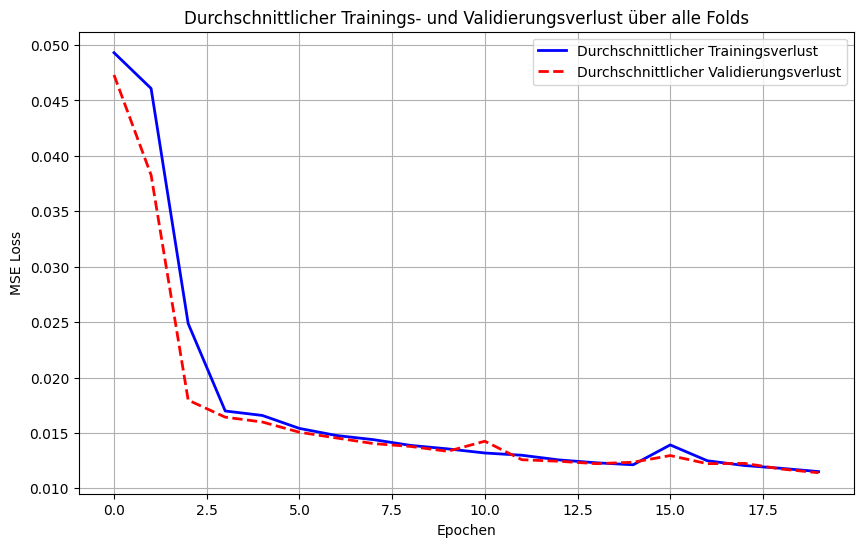

In [ ]:
num_epochs = len(fold_results[0]['loss'])
avg_train_loss = np.zeros(num_epochs)
avg_val_loss = np.zeros(num_epochs)

for history in fold_results:
    avg_train_loss += np.array(history['loss'])
    avg_val_loss += np.array(history['val_loss'])

avg_train_loss /= len(fold_results)
avg_val_loss /= len(fold_results)

plt.figure(figsize=(10, 6))
for fold, history in enumerate(fold_results):
    plt.plot(history['loss'], label=f"Train Loss Fold {fold+1}")
    plt.plot(history['val_loss'], linestyle="--", label=f"Val Loss Fold {fold+1}")

plt.xlabel("Epochen")
plt.ylabel("MSE Loss")
plt.title("Trainings- vs. Validierungsverlust für alle Folds")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(avg_train_loss, color="blue", linewidth=2, label="Durchschnittlicher Trainingsverlust")
plt.plot(avg_val_loss, color="red", linewidth=2, linestyle="--", label="Durchschnittlicher Validierungsverlust")

plt.xlabel("Epochen")
plt.ylabel("MSE Loss")
plt.title("Durchschnittlicher Trainings- und Validierungsverlust über alle Folds")
plt.legend()
plt.grid()
plt.show()

In [ ]:
print(f"Shape von y_val (echte Werte): {y_val.shape}") 
print(f"Shape von y_pred (Vorhersagen): {y_pred.shape}") 

Shape von y_val (echte Werte): (12082, 96)
Shape von y_pred (Vorhersagen): (12082, 96)


In [ ]:
baseline_pred = np.mean(true_values, axis=0)  # Durchschnitt pro Zeitschritt (96 Werte)
baseline_pred = np.tile(baseline_pred, (len(true_values), 1))  # Form anpassen auf (Samples, 96)

# Berechnung des MSE zwischen echter Zielvariable und der Baseline
baseline_mse = mean_squared_error(true_values, baseline_pred)

print(f"Baseline-MSE: {baseline_mse:.4f}")

Baseline-MSE: 0.0151


In [ ]:
model.save("lstm_first_run.keras")
print("Modell wurde gespeichert.")

Modell wurde gespeichert.


In [ ]:
random_index = np.random.randint(0, len(X_final))
example_input = X_final[random_index].reshape(1, 480, -1)

true_output = y_final[random_index]

from tensorflow.keras.models import load_model

model = load_model("lstm_first_run.keras")
predicted_output = model.predict(example_input)

predicted_output = predicted_output.flatten()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


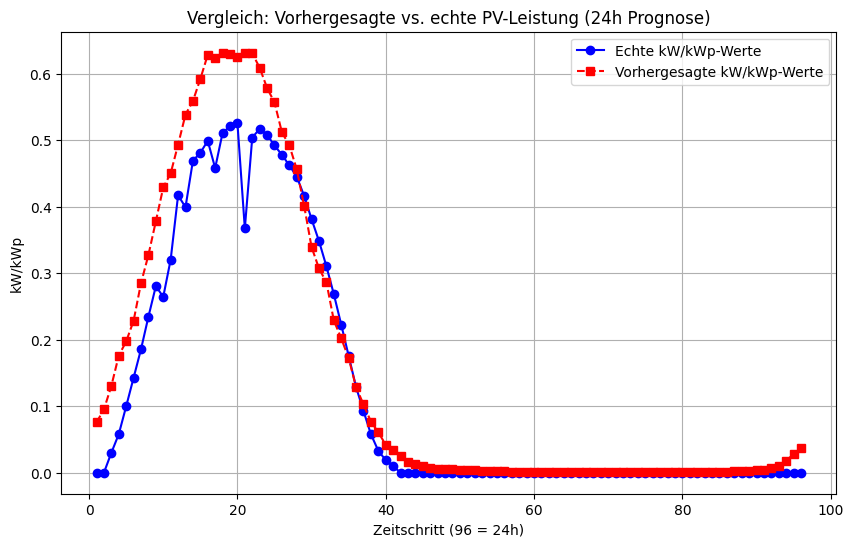

In [ ]:
time_steps = np.arange(1, 97) 

plt.figure(figsize=(10, 6))

plt.plot(time_steps, true_output, label="Echte kW/kWp-Werte", marker='o', color="blue")
plt.plot(time_steps, predicted_output, label="Vorhergesagte kW/kWp-Werte", linestyle="--", marker='s', color="red")

plt.xlabel("Zeitschritt (96 = 24h)")
plt.ylabel("kW/kWp")
plt.title("Vergleich: Vorhergesagte vs. echte PV-Leistung (24h Prognose)")
plt.legend()
plt.grid()
plt.show()

In [ ]:
print(f"y_final.shape: {y_final.shape}")
print(f"y.shape: {y.shape}") 

X_final.shape: (438007, 96)
X.shape: (60410, 96)
